# Assignment 5

Task 1: Use PCA from previous assignment to convert data from 4D to 2D. If you did not manage to implement PCA, you can simply use first 2 dimensions of the database. (4 points if PCA is used, otherwise 1 point)

Task 2a: Implement kNN classification algorithm and apply it to classify iris database. (2 points)

Task 2b: Try different values of k = {1, 2, 3, 4, 5} and print prediction accuracy for validation set. Please select optimal value of k and justify your selection. (3 points)

Task 3: Implement random forest classification and apply it to classify iris database. Use any reasonable parameters you want. (3 points)

Taks 4: Visualize results of kNN and random forests (4 points)

In [31]:
# Load packages as usual
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
import matplotlib.cm as cm
import numpy.matlib
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


# Manipulating figure sizes
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15,7)
matplotlib.rc('font', size=15)
matplotlib.rc('axes', titlesize=15)

### Database

We have a database of iris flowers, where each datapoint is defined with 4 features: a) sepal length in cm, b) sepal width in cm, c) petal length in cm, d) petal width in cm. Each datapoint has also a label from the set: Iris Setosa (label = 0), Iris Versicolour (label = 1), Iris Virginica (label = 2).

### Reading data

In [32]:
def __read(fileName, pTrainSamples = 0.6, pValidSamples = 0.2):
    emp_df = pd.read_csv(fileName)
    values = emp_df.values
    # Changed from np.float
    values = emp_df.values.astype(float)
    
    nTrainSamples = int(values.shape[0] * pTrainSamples)
    nValidSamples = int(values.shape[0] * pValidSamples)
    
    trainingFeatures = values[0:nTrainSamples, 0:-1]
    trainingLabels   = values[0:nTrainSamples, -1]
    validationFeatures = values[nTrainSamples:nTrainSamples + nValidSamples, 0:-1]
    validationLabels   = values[nTrainSamples:nTrainSamples + nValidSamples, -1]
    testingFeatures    = values[nTrainSamples + nValidSamples:, 0:-1]
    testingLabels      = values[nTrainSamples + nValidSamples:, -1]
    # Changed from np.float and np.int
    return trainingFeatures.astype(float), trainingLabels.astype(int), \
           validationFeatures.astype(float), validationLabels.astype(int), \
           testingFeatures.astype(float), testingLabels.astype(int)


trainingFeatures, trainingLabels, validationFeatures, validationLabels, testingFeatures, testingLabels = __read('./iris_new.csv')
print('shape training = ', trainingFeatures.shape)
print('shape validation = ', validationFeatures.shape)
print('shape testing = ', testingFeatures.shape)

shape training =  (88, 4)
shape validation =  (29, 4)
shape testing =  (31, 4)


### Converting data to two dimensions using PCA

The conversion to 2D from 4D input is needed to simplify visualization of the results. Please generate PCA on the training, and then convert training and testing data from 4D to 2D. 

In [53]:
def __PCA(data):
    data = data.T # Transpose the data so that each row is a feature (this was the format of the data in the previous assigment)
    
    # Normalize the data
    mean = np.mean(data, 1) # Compute the mean of the data
    mean_cols = np.matlib.repmat(mean, data.shape[1], 1).T # Repeat the mean across columns (so that it can be subtracted from each data point)
    data_cent = data - mean_cols # Center the data

    # Compute the covariance matrix
    covar = np.cov(data_cent)

    # Compute the eigenvectors and eigenvalues of the covariance matrix
    eigVals, eigVecs = np.linalg.eigh(covar) # Returned in ascending order
    
    # Reverse the order of the eigenvalues and eigenvectors so that they are in decreasing order
    PCevals = np.flip(eigVals) # Reverse the order of the eigenvalues
    PCevecs = np.flip(eigVecs, 1) # Reverse the order of the eigenvectors (columns)
    return PCevals, PCevecs


def __transformData(features, PCevecs):
    return np.dot(features,  PCevecs[:, 0:2])


PCevals, PCevecs = __PCA(trainingFeatures)
trainingFeatures2D = __transformData(trainingFeatures, PCevecs)
validationFeatures2D = __transformData(validationFeatures, PCevecs)
testingFeatures2D = __transformData(testingFeatures, PCevecs)
print('shape training = ', trainingFeatures2D.shape)
print('shape validation = ', validationFeatures2D.shape)
print('shape testing = ', testingFeatures2D.shape)
print('explained variance = ', np.sum(PCevals[0:2])/np.sum(PCevals))

shape training =  (88, 2)
shape validation =  (29, 2)
shape testing =  (31, 2)
explained variance =  0.9767350808869706


### Visualizing 2D data

This is visualization of the training data with labels.

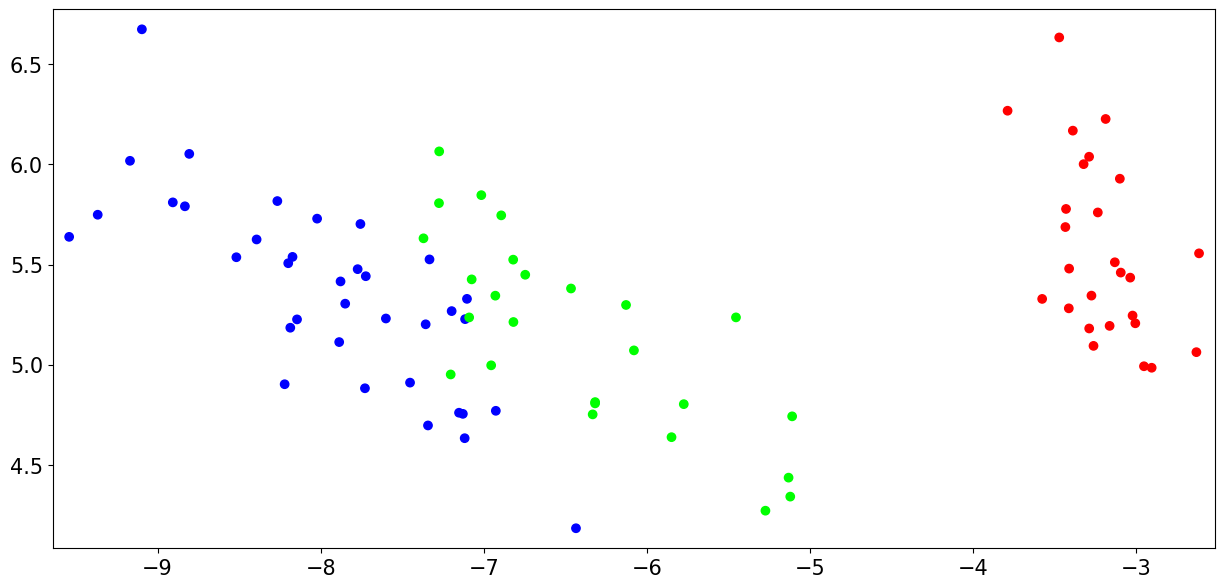

In [34]:
def __visualizeLabels(features, referenceLabels):
    plt.figure()
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold  = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
    y = referenceLabels

    plt.scatter(features[:, 0], features[:, 1], c = y, cmap = cmap_bold)
    plt.xlim(features[:, 0].min() - 0.1, features[:, 0].max() + 0.1)
    plt.ylim(features[:, 1].min() - 0.1, features[:, 1].max() + 0.1)
    plt.show()
    t = 0
    
__visualizeLabels(trainingFeatures2D, trainingLabels)

### k-NN implementation

Implement k-NN for prediction of iris labels. Test k-NN for different k-s and find the best one in the space of {1, 2, 3, 4, 5}. Use validation set for testing different k values.

Please note that it is NOT allowed to use KNeighborsClassifier or other existing implementation of k-NN. We expect that can implement it yourself.


In [35]:
def __kNNTest(trainingFeatures2D, trainingLabels, n_neighbors, validationFeatures2D, validationLabels):
    predictions = []
    for validationFeature in validationFeatures2D:
        # Calcualte euclidean distances and sort them
        distances = np.sqrt(np.sum((trainingFeatures2D - validationFeature)**2, axis=1))
        sortedIndex = np.argsort(distances)

        # Take the n first labels
        closestLabels = trainingLabels[sortedIndex[0:n_neighbors]]
        
        # Get the most common label (bincount returns the number of occurences of each label)
        prediction = np.argmax(np.bincount(closestLabels))
        predictions.append(prediction)

    accuracy = np.sum(predictions == validationLabels) / len(validationLabels)
    return accuracy

# Best to pick 3 or 5 as both are odd numbers and have a good accuracy (100%)
for n in range(1, 6):
    print('accuracy (n = ', n, ') = ', __kNNTest(trainingFeatures2D, trainingLabels, n, validationFeatures2D, validationLabels))


accuracy (n =  1 ) =  0.9310344827586207
accuracy (n =  2 ) =  0.9655172413793104
accuracy (n =  3 ) =  1.0
accuracy (n =  4 ) =  1.0
accuracy (n =  5 ) =  1.0


### Random forests implementation

Implement random forest for prediciton of iris labels. Select any reasonable configuration of parameters for the random forest predictor

Here you are allowed to use existing implementations, please check RandomForestClassifier from sklearn

In [54]:
def __randomForests(trainingFeatures2D, trainingLabels):
    predictor = RandomForestClassifier(n_estimators=100) # TODO: Change the number of trees
    predictor.fit(trainingFeatures2D, trainingLabels)
    return predictor

predictor = __randomForests(trainingFeatures2D, trainingLabels)

### Visualizing predictor boundaries

Modify function __visualizeLabels to visualize not only labels but also decision boundaries of a predictor. Apply kNN classifier with optimal k on testing features and visualize the obtained results. Visualize the obtained results in comparion with the true testing labels. Apply random forest classifier on testing features and visualize the obtained results.

Here, you are allowed to use KNeighborsClassifier in __kNN.

Hint: check this example https://stackoverflow.com/questions/41138706/recreating-decision-boundary-plot-in-python-with-scikit-learn-and-matplotlib

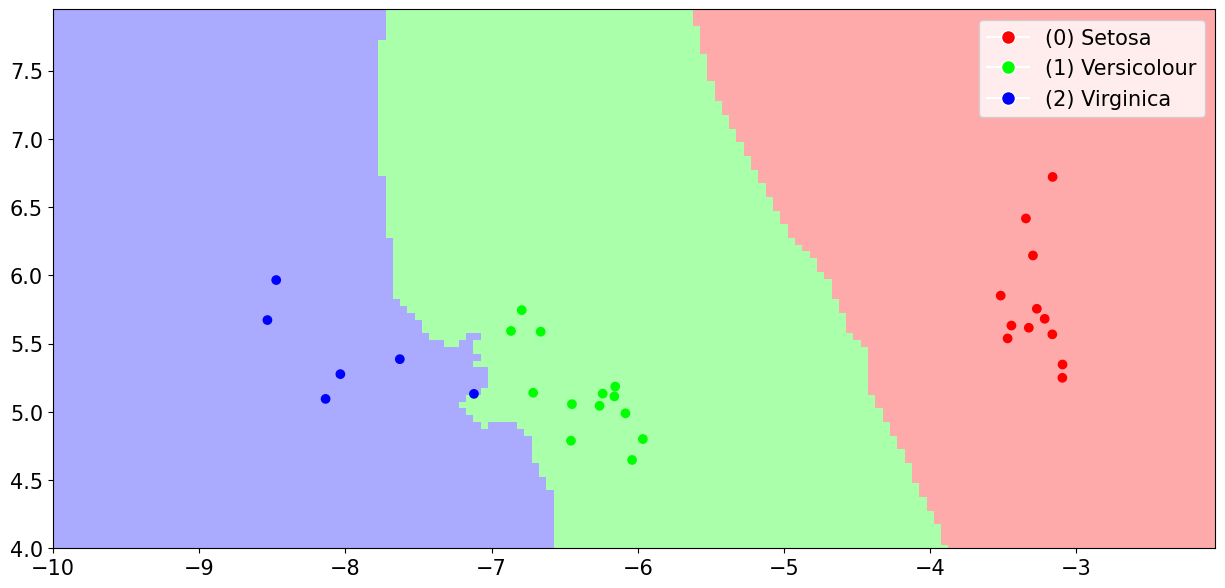

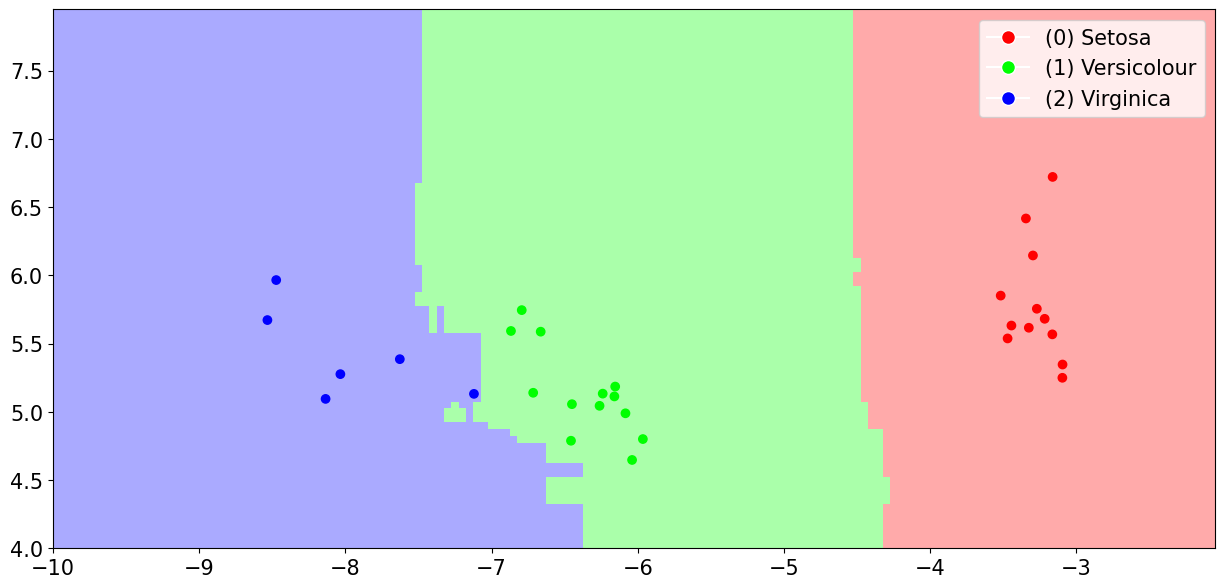

In [ ]:
from matplotlib.lines import Line2D

def __kNN(trainingFeatures2D, trainingLabels, n_neighbors):
    predictor = KNeighborsClassifier(n_neighbors=n_neighbors)
    predictor.fit(trainingFeatures2D, trainingLabels)
    return predictor

def __visualizePredictions(predictor, features, referenceLabels):
    plt.figure()
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold  = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
    h = 0.05
    y = referenceLabels
    
    # x_min, x_max = features[:, 0].min() - 1, features[:, 0].max() + 1
    # y_min, y_max = features[:, 1].min() - 1, features[:, 1].max() + 1
    # xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
    #                      np.arange(y_min, y_max, h))
    # Z = predictor.predict(np.c_[xx.ravel(), yy.ravel()])
    # Z = Z.reshape(xx.shape)

    x0 = features[:, 0]
    x1 = features[:, 1]

    x0_min, x0_max = np.round(x0.min())-1, np.round(x0.max()+1)
    x1_min, x1_max = np.round(x1.min())-1, np.round(x1.max()+1)

    x0_axis_range = np.arange(x0_min,x0_max, h)
    x1_axis_range = np.arange(x1_min,x1_max, h)

    xx, yy = np.meshgrid(x0_axis_range, x1_axis_range)

    Z = predictor.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape) # Reshape the predictions to the meshgrid shape
    
    plt.pcolormesh(xx, yy, Z, cmap = cmap_light)
    # Plot also the training points
    plt.scatter(features[:, 0], features[:, 1], c = y, cmap = cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    # Add legend
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='(0) Setosa', markerfacecolor='#FF0000', markersize=10),
                       Line2D([0], [0], marker='o', color='w', label='(1) Versicolour', markerfacecolor='#00FF00', markersize=10),
                       Line2D([0], [0], marker='o', color='w', label='(2) Virginica', markerfacecolor='#0000FF', markersize=10)]
    plt.legend(handles=legend_elements, loc='upper right')
    plt.show()

# TODO: check whether it should be 3 or 5
k = 3
kNNPredictor = __kNN(trainingFeatures2D, trainingLabels, k)
RFPredictor  = __randomForests(trainingFeatures2D, trainingLabels)
__visualizePredictions(kNNPredictor, testingFeatures2D, testingLabels)
__visualizePredictions(RFPredictor, testingFeatures2D, testingLabels)